In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

[autoreload of spconv.functional failed: Traceback (most recent call last):
  File "/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/IPython/extensions/autoreload.py", li

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import torch
import torch.nn.functional as F
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool
from second.pytorch.builder import (box_coder_builder, input_reader_builder,
                                    lr_scheduler_builder, optimizer_builder,
                                    second_builder)
from second.data.preprocess import merge_second_batch, merge_second_batch_multigpu
from second.pytorch.train import _worker_init_fn

from second.pytorch.train import example_convert_to_torch

from second.sphere.conv import init_depth_from_feature, depth_to_3D


## Read Config file

In [42]:
# config_path = "/home/yy/deeplearning/deeplearning/mypackages/second/configs/car.lite.nb.config"
config_path = "/home/gx/GitHub/depconv/second/configs/car.fhd.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.train_input_reader
model_cfg = config.model.second
# config_tool.change_detection_range(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


## Build Network, Target Assigner and Voxel Generator

In [4]:
# ckpt_path = "/home/gx/GitHub/depconv/second/depconv27/voxelnet-102080.tckpt"
net = build_network(model_cfg).to(device).eval()
# net.load_state_dict(torch.load(ckpt_path))
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator

dataset = input_reader_builder.build(
    input_cfg,
    model_cfg,
    training=True,
    voxel_generator=voxel_generator,
    target_assigner=target_assigner,
    multi_gpu=False)

num_gpu=1
collate_fn= merge_second_batch
multi_gpu = False
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=input_cfg.batch_size * num_gpu,
        shuffle=True,
#         num_workers=input_cfg.preprocess.num_workers * num_gpu,
        num_workers=1,
        pin_memory=False,
        collate_fn=collate_fn,
        worker_init_fn=_worker_init_fn,
        drop_last=not multi_gpu)

dense_shape =  [1, 63, 512, 512, 16]
[ 64 512 512]
rpn debug, final_num_filters =  192
rpn debug, num_cls =  2
rpn debug, num_anchor_per_loc =  2
feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)
feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)
remain number of infos: 3712


## Generate Anchors

In [43]:
grid_size = voxel_generator.grid_size
feature_map_size = grid_size[:2] // config_tool.get_downsample_factor(model_cfg)
feature_map_size = [*feature_map_size, 1][::-1]

anchors = target_assigner.generate_anchors(feature_map_size)["anchors"]
anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
anchors = anchors.view(1, -1, 7)

feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)


## Read KITTI infos
you can load your custom point cloud.

In [6]:
info_path = input_cfg.dataset.kitti_info_path
root_path = Path(input_cfg.dataset.kitti_root_path)
with open(info_path, 'rb') as f:
    infos = pickle.load(f)

## Load Point Cloud, Generate Voxels

In [7]:
info = infos[564]
v_path = info["point_cloud"]['velodyne_path']
v_path = str(root_path / v_path)
points = np.fromfile(
    v_path, dtype=np.float32, count=-1).reshape([-1, 4])
# voxels, coords, num_points = voxel_generator.generate(points, max_voxels=90000)
# print(voxels.shape)
# add batch idx to coords
# coords = np.pad(coords, ((0, 0), (1, 0)), mode='constant', constant_values=0)
# voxels = torch.tensor(voxels, dtype=torch.float32, device=device)
# coords = torch.tensor(coords, dtype=torch.int32, device=device)
# num_points = torch.tensor(num_points, dtype=torch.int32, device=device)

## Detection

In [8]:
# example = {
#     "anchors": anchors,
#     "voxels": voxels,
#     "num_points": num_points,
#     "coordinates": coords,
# }
# pred = net(example)[0]
examples = []
loop_i = 0
for example in dataloader:
    loop_i += 1
    if loop_i > 10:
        break
    examples.append(example)
#     print(example)



WORKER 0 seed: 1589682607


/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: Invalid use of Function(<built-in function getitem>) with argument(s) of type(s): (array(float32, 3d, C), Tuple(slice<a:b>, list(int64), slice<a:b>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
In definition 2:
    All templates rejected with literals.
In definition 3:
    All templates rejected without literals.
In definition 4:
    All templates rejected with literals.
In definition 5:
    All templates rejected without literals.
In definition 6:
    All templates rejected with literals.
In definition 7:
    All templates rejected without literals.
In definition 8:
    All templates rejected with literals.
In definition 9:
    All templates rejected without literals.
In definition 

In [9]:
examples[1]['voxels'].shape

(264232, 1, 4)

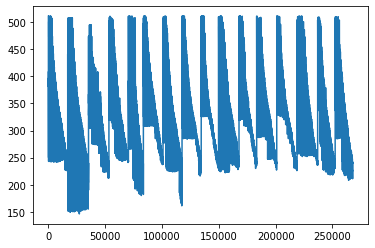

In [10]:
plt.plot(examples[4]['coordinates'][:,3])

In [11]:
example.keys()

dict_keys(['points', 'voxels', 'num_points', 'coordinates', 'num_voxels', 'metrics', 'calib', 'anchors', 'gt_names', 'labels', 'reg_targets', 'importance', 'metadata'])

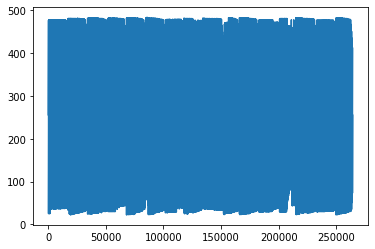

In [36]:
plt.plot(examples[1]['coordinates'][:,2])

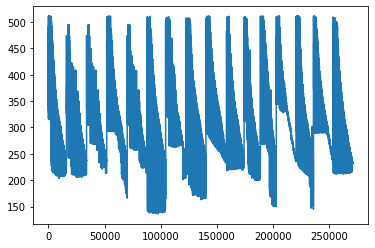

In [37]:
plt.plot(examples[0]['coordinates'][:,3])

(array([1.000e+00, 0.000e+00, 6.000e+00, 0.000e+00, 0.000e+00, 1.300e+01,
        0.000e+00, 0.000e+00, 4.100e+01, 0.000e+00, 7.300e+01, 0.000e+00,
        0.000e+00, 8.800e+01, 0.000e+00, 0.000e+00, 7.700e+01, 0.000e+00,
        8.300e+01, 0.000e+00, 0.000e+00, 8.300e+01, 0.000e+00, 0.000e+00,
        8.600e+01, 0.000e+00, 8.300e+01, 0.000e+00, 0.000e+00, 8.400e+01,
        0.000e+00, 0.000e+00, 8.900e+01, 0.000e+00, 8.500e+01, 0.000e+00,
        0.000e+00, 8.800e+01, 0.000e+00, 0.000e+00, 8.800e+01, 0.000e+00,
        9.400e+01, 0.000e+00, 0.000e+00, 1.000e+02, 0.000e+00, 0.000e+00,
        9.900e+01, 0.000e+00, 8.400e+01, 0.000e+00, 0.000e+00, 7.600e+01,
        0.000e+00, 0.000e+00, 9.100e+01, 0.000e+00, 7.500e+01, 0.000e+00,
        0.000e+00, 7.900e+01, 0.000e+00, 0.000e+00, 7.800e+01, 0.000e+00,
        8.000e+01, 0.000e+00, 0.000e+00, 8.900e+01, 0.000e+00, 0.000e+00,
        8.400e+01, 0.000e+00, 7.800e+01, 0.000e+00, 0.000e+00, 7.700e+01,
        0.000e+00, 0.000e+00, 1.060e+0

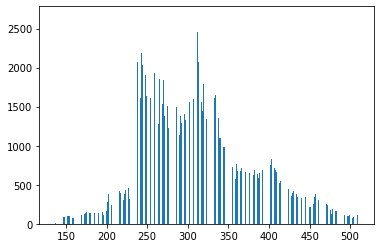

In [39]:
plt.hist(examples[0]['coordinates'][:,3], 1000)

In [15]:
examples[0]['coordinates'].shape

(271341, 4)

In [16]:
example = examples[5]
example = example_convert_to_torch(example, torch.float32)

with torch.no_grad():
    pred = net(example)


voxel_features shape:  torch.Size([265472, 4])
sparse_shape : [ 64 512 512]
NCDHW =  16 64 3 64 64


In [17]:
pred[3]['box3d_lidar']

tensor([[ 39.0064, -27.6246,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1656],
        [ 17.4588, -11.8943,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1407],
        [  4.4980,  -3.2925,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1407],
        [ 21.1619, -14.3520,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1407],
        [ 24.8650, -16.8097,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1407],
        [ 28.5681, -19.2674,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1407],
        [ 10.0526,  -6.9790,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1407],
        [ 45.2321, -30.3269,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1407],
        [ 48.9352, -32.7846,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1407],
        [ 35.9743, -24.1827,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1407],
        [ 32.2712, -21.7250,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1407],
        [ 13.7557,  -9.4367,  -0.9582,   1.6494,   4.1429,   1.5475,   2.1407],
        [ 55.3766, -35.0981,  -0.9582,  

In [18]:
boxes = example['anchors']
boxes
boxes.shape


torch.Size([16, 8192, 7])

In [19]:
boxes[0][1]

tensor([ 0.7857, -0.7857, -1.0000,  1.6000,  3.9000,  1.5600,  0.7854],
       device='cuda:0')

In [20]:
sum(example['points'])

array([4920003.  ,   87639.5 , -306394.62,   69904.25], dtype=float32)

In [21]:
sum(example['voxels'])

tensor([[4356288.0000,   68672.8203, -271758.4062,   61996.5820]],
       device='cuda:0')

In [22]:
example['anchors'][0][3027]

tensor([19.5541,  7.9571, -1.0000,  1.6000,  3.9000,  1.5600, -0.3865],
       device='cuda:0')

In [23]:
points

array([[69.166,  7.675,  2.562,  0.   ],
       [75.051,  9.167,  2.766,  0.   ],
       [74.998,  9.4  ,  2.765,  0.   ],
       ...,
       [ 3.657, -1.383, -1.707,  0.42 ],
       [ 3.659, -1.377, -1.707,  0.52 ],
       [ 3.914, -1.461, -1.832,  0.   ]], dtype=float32)

In [24]:
example["points"][0].shape

(4,)

In [25]:
res = voxel_generator.generate(
                points, 20000)
res['voxels'].shape

(20000, 1, 4)

## Simple Vis

In [26]:
# %config InlineBackend.figure_format = 'retina'


# boxes_lidar = boxes.detach().cpu().numpy()
# boxes_ldar = pred[1]['box3d_lidar']
# vis_voxel_size = [0.1, 0.1, 0.1]
# vis_point_range = [-50, -30, -3, 50, 30, 1]
# vis_point_range = [0, -40, -3, 80, 40, 1]
# bev_map = simplevis.point_to_vis_bev(example["points"], vis_voxel_size, vis_point_range)
# bev_map = simplevis.draw_box_in_bev(bev_map, vis_point_range, boxes_lidar, [0, 255, 0], 2)
# bev_map = simplevis.draw_box_in_bev(bev_map,vis_point_range, boxes_lidar[0][0:8000:80,:].cpu().numpy(), [0,255,0], 2)

In [27]:
# plt.imshow(bev_map)



In [28]:
# bev_map = simplevis.kitti_vis(example["points"][0], boxes[0].cpu().numpy())

In [29]:
# plt.imshow(bev_map)


In [30]:
example

{'points': array([[ 5.5192e+01,  6.5590e+00,  2.0890e+00,  0.0000e+00],
        [ 2.9624e+01,  6.1860e+00,  1.2320e+00,  1.7000e-01],
        [ 2.9540e+01,  6.2650e+00,  1.2300e+00,  2.9000e-01],
        ...,
        [ 6.2170e+00, -5.0000e-02, -1.6210e+00,  1.2000e-01],
        [ 6.2090e+00, -3.0000e-02, -1.6190e+00,  2.1000e-01],
        [ 6.2110e+00, -1.1000e-02, -1.6200e+00,  1.8000e-01]],
       dtype=float32),
 'voxels': tensor([[[ 5.5192e+01,  6.5590e+00,  2.0890e+00,  0.0000e+00]],
 
         [[ 2.9624e+01,  6.1860e+00,  1.2320e+00,  1.7000e-01]],
 
         [[ 2.9540e+01,  6.2650e+00,  1.2300e+00,  2.9000e-01]],
 
         ...,
 
         [[ 6.9460e+00, -5.6000e-02, -1.6160e+00,  7.0000e-02]],
 
         [[ 6.9360e+00, -2.3000e-02, -1.6130e+00,  0.0000e+00]],
 
         [[ 6.9330e+00, -2.0000e-03, -1.6120e+00,  0.0000e+00]]],
        device='cuda:0'),
 'num_points': tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int32),
 'coordinates': tensor([[  0,  25, 294, 484

In [31]:
example = example_convert_to_torch(example, device=torch.device("cuda"))


voxels = example["voxels"]
num_points = example["num_points"]
coors = example["coordinates"]
batch_anchors = example["anchors"]
# feature = example["feature"]
batch_size_dev = batch_anchors.shape[0]
voxel_features = net.voxel_feature_extractor(voxels, num_points,
                                                      coors)
spatial_features = net.middle_feature_extractor(
            voxel_features, coors, batch_size_dev)
# vfeatures = net.voxel_feature_extractor(voxels, num_points, coors)
# preds_dict = net.network_forward(voxels, num_points, coors, batch_size_dev)
# spatial_features = net.feature_extractor(feature)

voxel_features shape:  torch.Size([265472, 4])
sparse_shape : [ 64 512 512]
NCDHW =  16 64 3 64 64


/home/gx/GitHub/depconv/second/pytorch/train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v, dtype=torch.float32, device=device).to(dtype)
/home/gx/GitHub/depconv/second/pytorch/train.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v, dtype=torch.int32, device=device)
/home/gx/GitHub/depconv/second/pytorch/train.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  example_torch[k] = torch.tensor(v)
/home/gx/GitHub/depconv/second/pytorch/train.py:52: UserWarning: To copy construct from a tensor, it is recommended to use source

In [32]:
spatial_features.shape

torch.Size([16, 192, 64, 64])

In [33]:
examples[5]['voxels'].shape

(265472, 1, 4)

/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


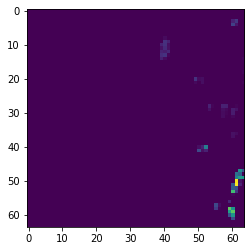

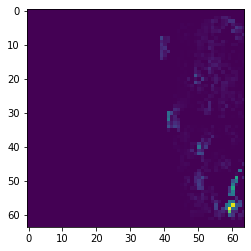

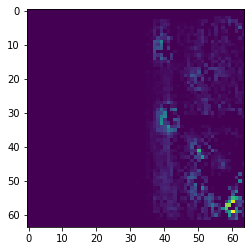

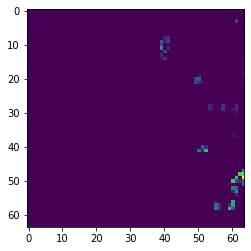

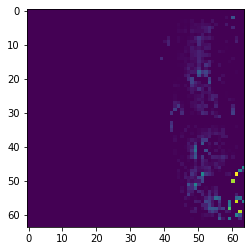

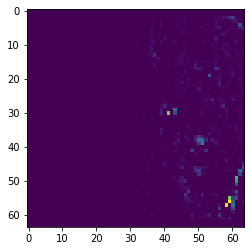

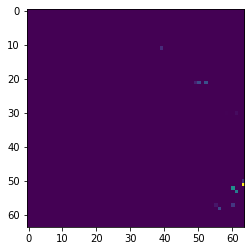

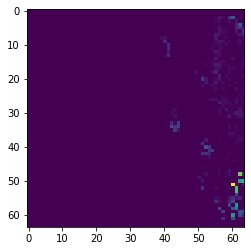

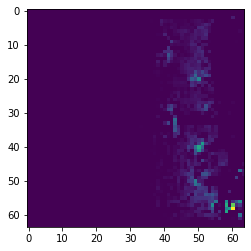

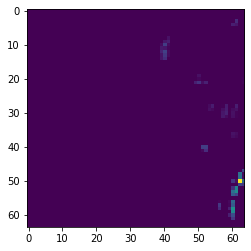

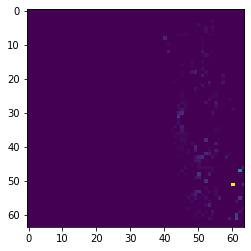

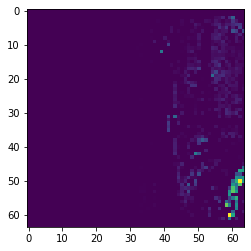

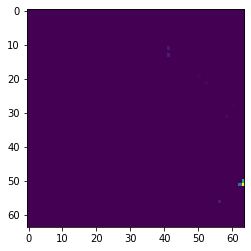

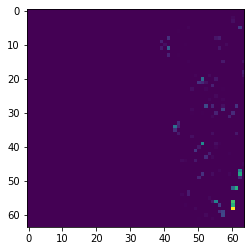

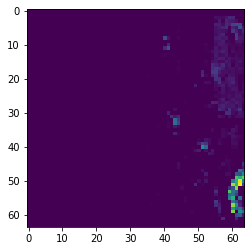

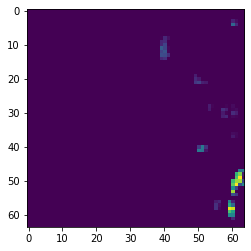

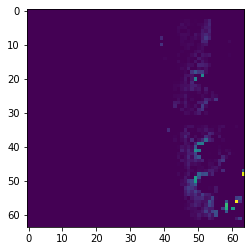

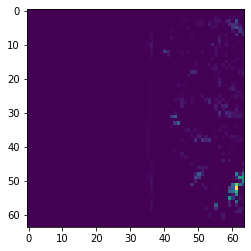

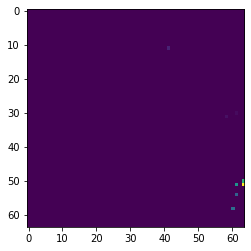

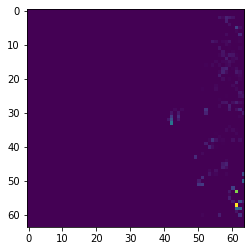

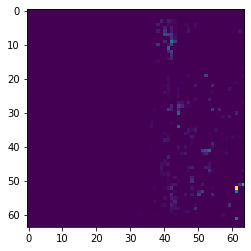

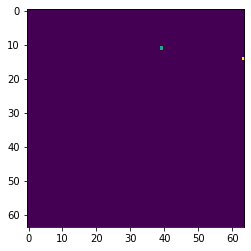

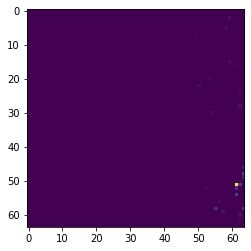

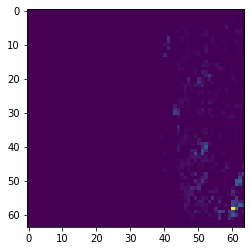

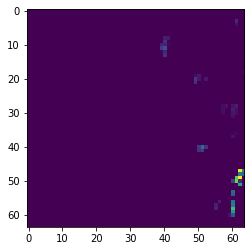

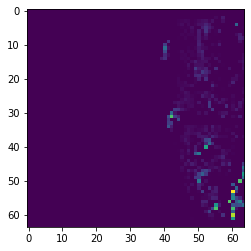

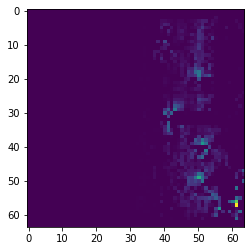

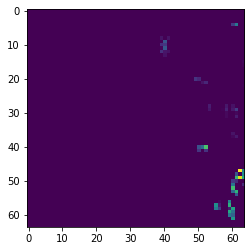

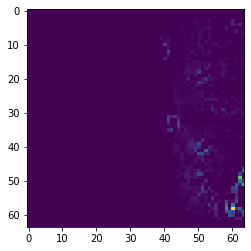

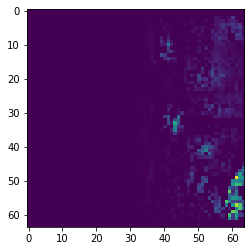

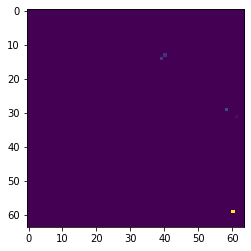

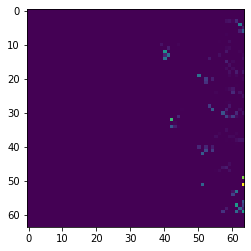

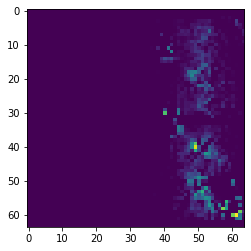

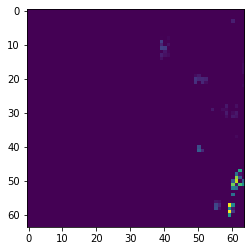

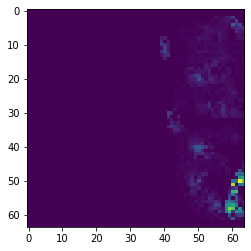

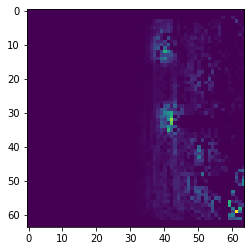

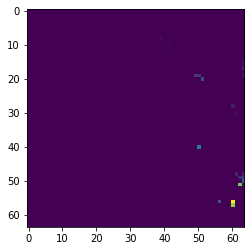

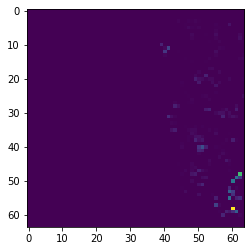

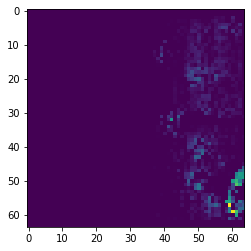

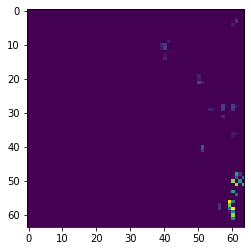

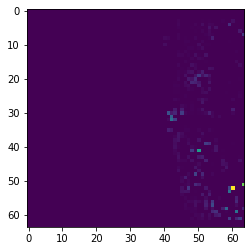

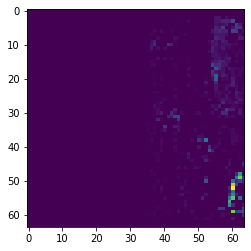

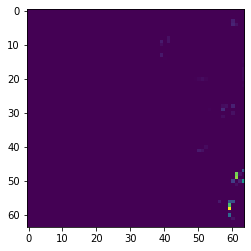

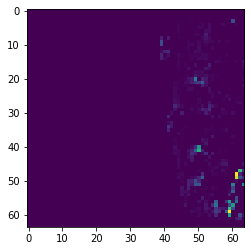

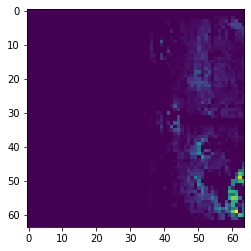

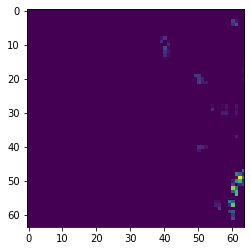

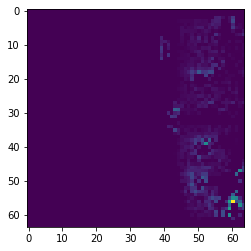

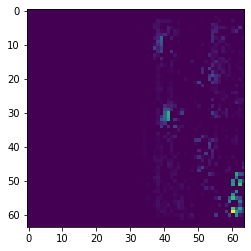

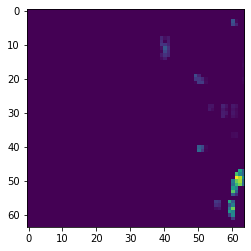

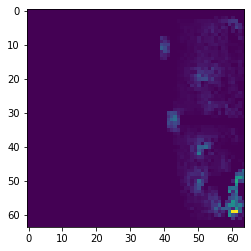

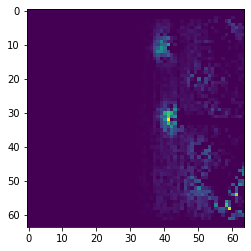

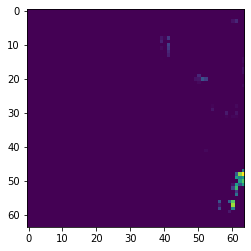

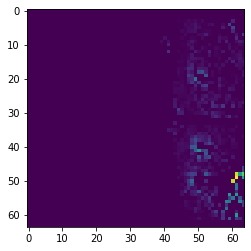

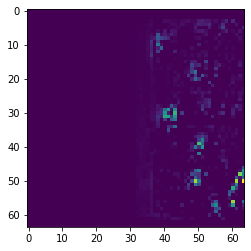

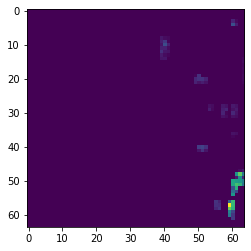

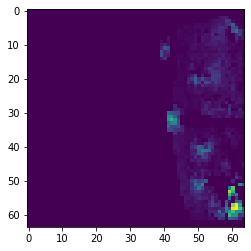

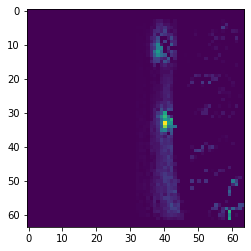

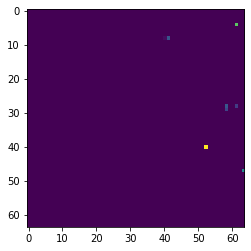

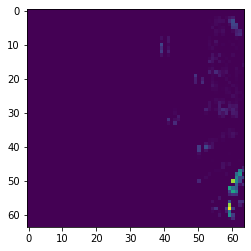

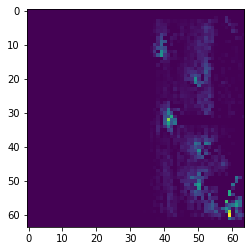

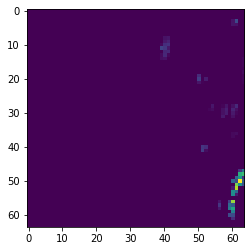

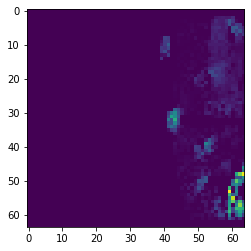

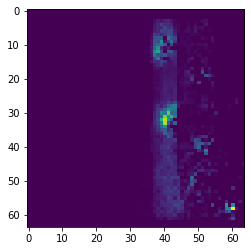

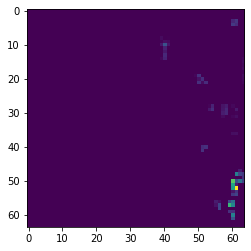

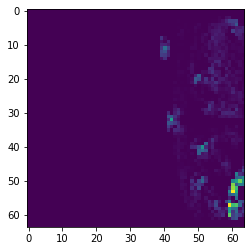

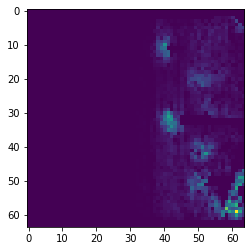

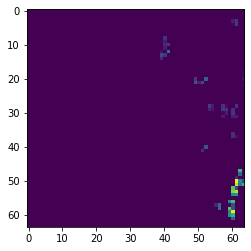

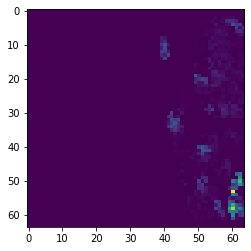

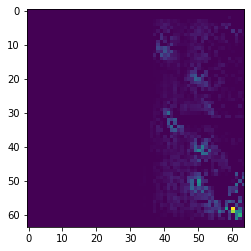

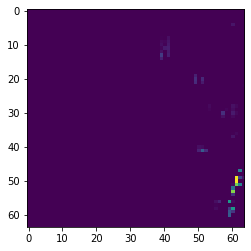

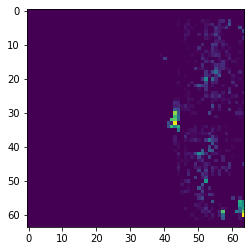

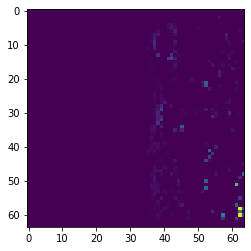

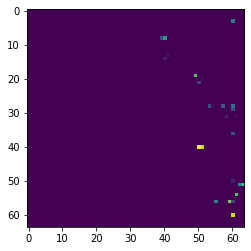

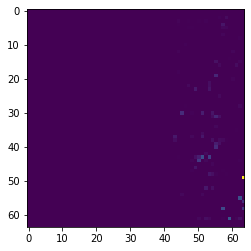

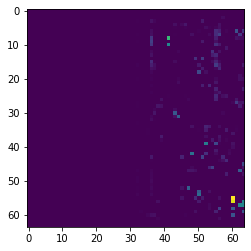

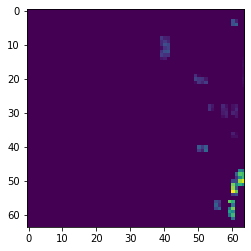

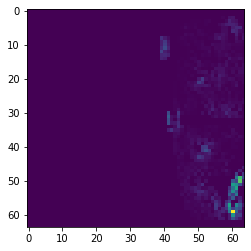

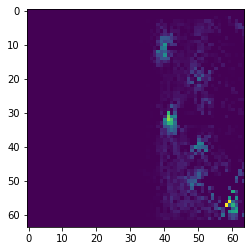

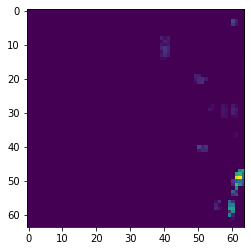

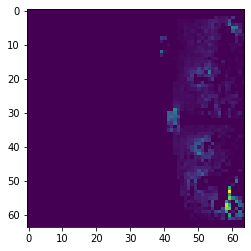

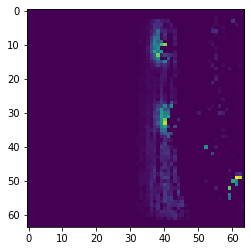

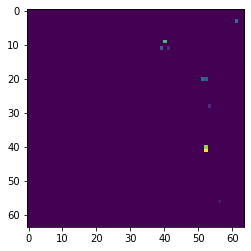

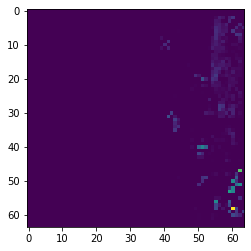

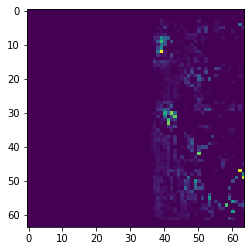

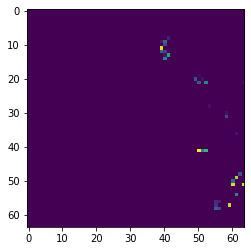

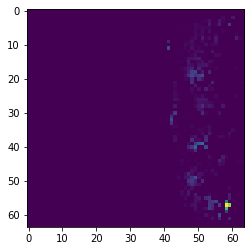

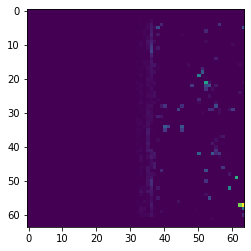

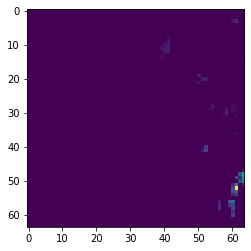

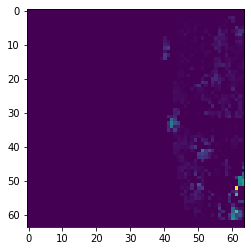

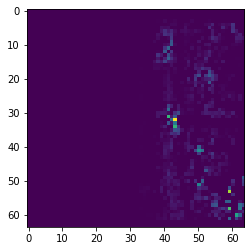

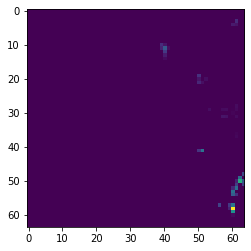

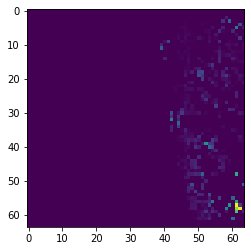

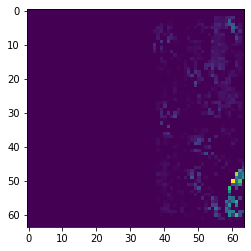

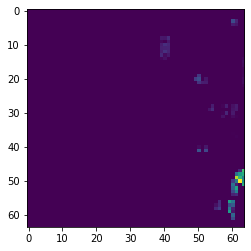

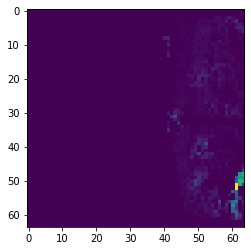

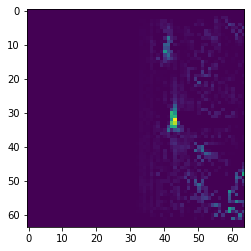

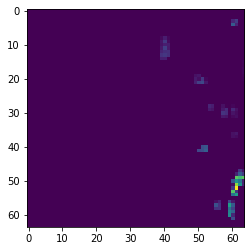

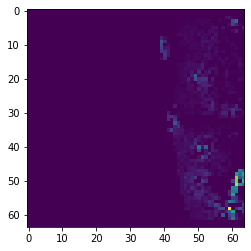

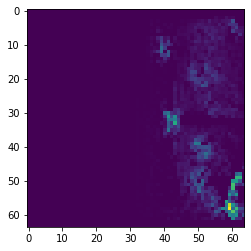

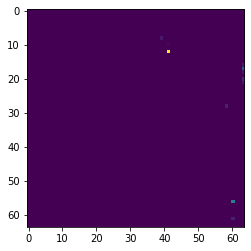

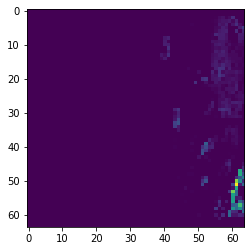

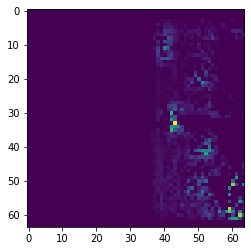

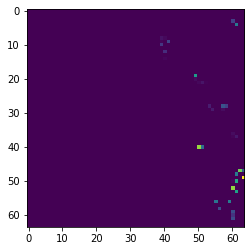

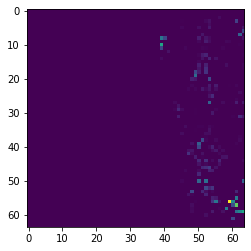

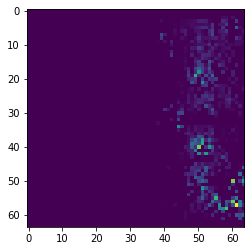

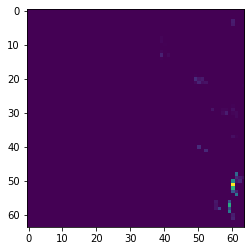

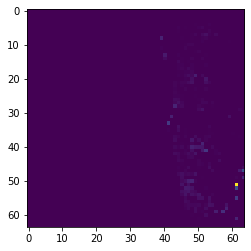

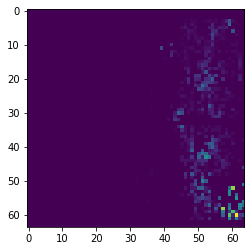

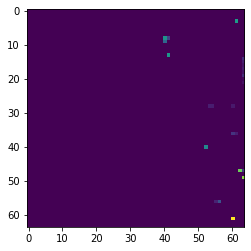

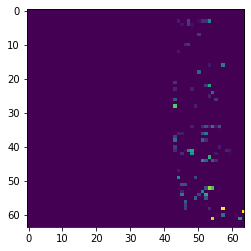

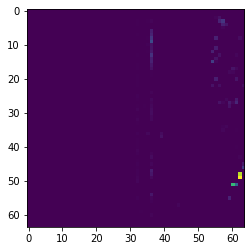

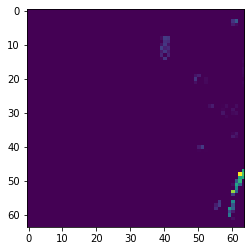

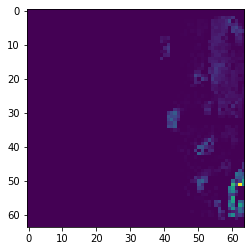

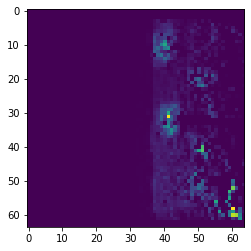

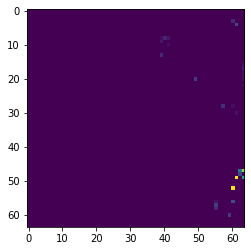

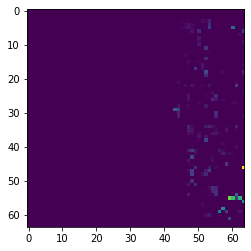

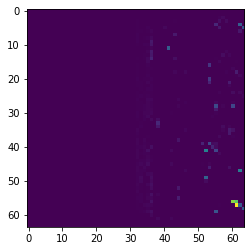

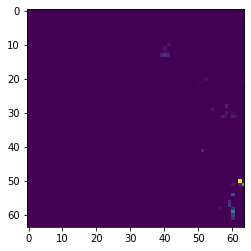

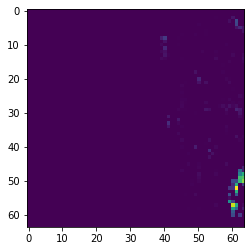

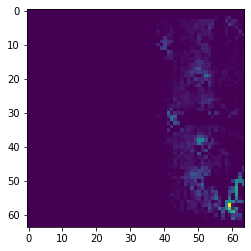

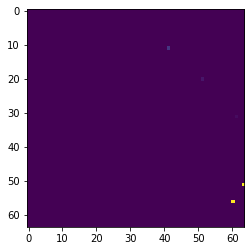

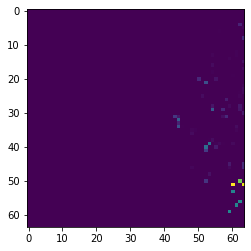

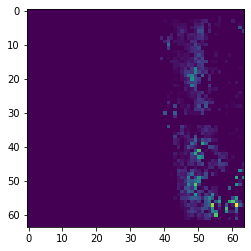

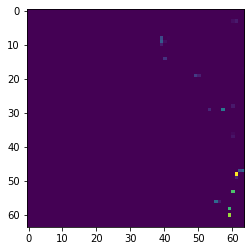

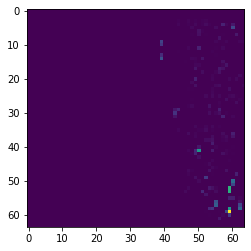

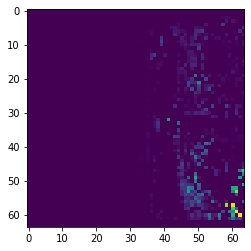

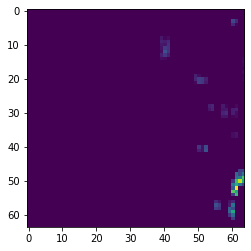

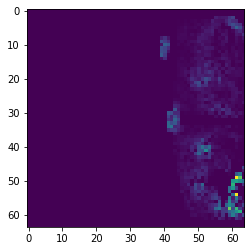

In [34]:
for i in range(128):
    plt.figure()
    plt.imshow(spatial_features[0][i].detach().cpu().numpy())

In [35]:

if feature.dim() == 3:
    feature = feature.unsqueeze(0)
with torch.no_grad():
    depth = init_depth_from_feature(feature, 512)

depth = F.max_pool2d(depth, 3, padding=1, stride=1)

NameError: name 'feature' is not defined

In [ ]:
depth.shape

In [ ]:
feature.shape

In [ ]:
# depth_to_3D(feature, depth.long(), D=256)

In [ ]:
plt.imshow(depth[0].detach().cpu().numpy())

In [ ]:
depth[0].detach().cpu().shape

In [ ]:
# depth[depth == 0 ] = 256

In [ ]:
def depth_bev(depth, R =500):
    """
    convert depth to bev
        depth: [H,W]
        to, 
    """
    H, W = depth.shape

    ret = np.zeros([R, W])
    for r in range(H):
        for i in range(W):
            d = int(depth[r][i])
            if d >= R:
                d = R-1
            ret[d][i] = 1
    return ret.T

plt.imshow(depth_bev(depth[0].detach().cpu().numpy()))

In [ ]:
depth1 = F.max_pool2d(depth, (2,1), padding=0, stride=(1,2)) / 2 
plt.imshow(depth_bev(depth1[0].detach().cpu().numpy(), 256))


In [ ]:
depth1

In [ ]:
depth2 = F.max_pool2d(depth1, (2,1), padding=0, stride=(1,2))/2
plt.imshow(depth_bev(depth2[0].detach().cpu().numpy(),  R=128))
print(depth2.shape)

In [ ]:
depth3 = F.avg_pool2d(depth2, (2,1), padding=0, stride=(1,2))/2
plt.imshow(depth_bev(depth3[0].detach().cpu().numpy(),  R=64))
print(depth3.shape)

In [ ]:
depth3.shape

In [ ]:
depth4 = F.max_pool2d(depth3, (2,1), padding=0, stride=(1,2)) /2 
plt.imshow(depth_bev(depth4[0].detach().cpu().numpy(), 32))
print(depth4.shape)

In [ ]:
depth5 = F.max_pool2d(depth4, (2,1), padding=(0,0), stride=(1,2)) /2 
plt.imshow(depth_bev(depth5[0].detach().cpu().numpy(), 16))
print(depth5.shape)

In [ ]:
bev = torch.tensor(depth_bev(depth[0].detach().cpu().numpy())).unsqueeze(0)
bev1 = F.max_pool2d(bev, 2, stride=2)
plt.imshow(bev1[0])

In [ ]:
bev2 = F.max_pool2d(bev1, 2, stride=2)
plt.imshow(bev2[0])

In [ ]:
bev3 = F.max_pool2d(bev2, 2, stride=2)
plt.imshow(bev3[0])

In [ ]:
bev4 = F.max_pool2d(bev3, 2, stride=2)
plt.imshow(bev4[0])

In [ ]:
bev5 = F.max_pool2d(bev4, 2, stride=2)
plt.imshow(bev5[0])

In [ ]:

# x = net.feature_extractor.conv1(feature, depth)
# x = net.feature_extractor.bn1(x)
# x = F.relu(x)

In [ ]:
# x.shape

In [ ]:
# plt.imshow(x[0][5].detach().cpu().numpy())

In [ ]:
depth_ = F.avg_pool2d(depth.float(), 2, padding=1, stride=(2,2)).long()

In [ ]:
plt.imshow(depth_[0].detach().cpu().numpy())

In [ ]:
for i in car_anchor_i:
    x = i % 64
    y = i // 64
    print(x,y)
    

In [ ]:
# example = examples[5]
# example = example_convert_to_torch(example, torch.float32)
feature = example['feature']
if feature.dim() == 3:
    feature = feature.unsqueeze(0)
with torch.no_grad():
    depth = init_depth_from_feature(feature, 512)
    
plt.figure(figsize = (25,25))
plt.imshow(depth[0].detach().cpu().numpy())

In [ ]:
example['metadata']

In [ ]:



car_anchor_i = []
for i, t in enumerate(example['reg_targets'][0]):
    if t.sum() > 0:
        print(i, t)
        car_anchor_i.append(i)
# car_anchor_i

car_anchors = example['anchors'][0][car_anchor_i]
car_anchors

vis_voxel_size = [0.01, 0.1, 0.1]
vis_point_range = [0, -30, -3, 6, 30, 1]
bev_map = simplevis.point_to_vis_bev(np.stack((np.log(r),points[:,1],points[:,2]), axis=1), vis_voxel_size, vis_point_range)

# bev_map = simplevis.kitti_vis(example['points'][0],
#                               car_anchors.cpu().numpy()  )
plt.figure(figsize = (10,10))
plt.imshow(bev_map)

In [ ]:

pnts = points
pnts[3] = np.log(pnts[3])

In [ ]:
plt.plot(points[:,x])

In [ ]:
r = np.sqrt(points[:,0]**2 + points[:,1]**2 + points[:,2]**2)

In [ ]:
plt.plot(r)

In [ ]:
plt.plot(np.log(r))

In [ ]:
np.stack((points[:,0],points[:,1], r), axis=1).shape

In [ ]:
points[:,1].shape